# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача проекта** - обучить модель и классифицировать комментарии на позитивные и негативные. 

**Цель проекта** - построить модель со значением метрики качества *F1* не меньше 0.75. 

**План проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Исходные данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [42]:
#загрузим необходимые библиотеки
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from lightgbm import LGBMClassifier

from textblob import TextBlob, Word

from tqdm.notebook import tqdm
tqdm.pandas()

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Загрузим датасет
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=0)
    print('platform')
else:
    df = pd.read_csv(pth2, index_col=0)
    print('remote')

remote


In [3]:
#посмотрим на выборку
df.sample

<bound method NDFrame.sample of                                                      text  toxic
0       Explanation\nWhy the edits made under my usern...      0
1       D'aww! He matches this background colour I'm s...      0
2       Hey man, I'm really not trying to edit war. It...      0
3       "\nMore\nI can't make any real suggestions on ...      0
4       You, sir, are my hero. Any chance you remember...      0
...                                                   ...    ...
159446  ":::::And for the second time of asking, when ...      0
159447  You should be ashamed of yourself \n\nThat is ...      0
159448  Spitzer \n\nUmm, theres no actual article for ...      0
159449  And it looks like it was actually you who put ...      0
159450  "\nAnd ... I really don't think you understand...      0

[159292 rows x 2 columns]>

In [4]:
#проверим пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [5]:
#преобразуем столбец с текстом в список текстов
df['text'] = df['text'].str.lower()

In [6]:
#очистим текст, оставив только буквенные численные символы
def clear_text(text):
    text = re.sub(r'[^a-z0-9]', ' ', text)
    text = text.split()
    return " ".join(text)

In [7]:
#применим функцию по очистке текста
df['clear_text'] = df['text'].apply(lambda x: clear_text(x))

In [8]:
#посмотрим, что получилось
df.head()

,text,toxic,clear_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


0    0.898388
1    0.101612
Name: toxic, dtype: float64


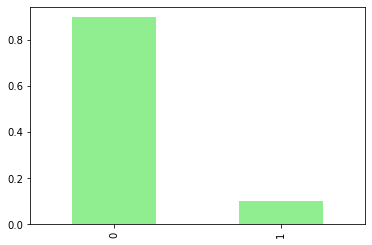

In [9]:
#исследуем баланс классов в целевом столбце

#относительная частота значений от 0 до 1
class_frequency = df['toxic'].value_counts(normalize=True)

#выведем относительное количество данных в двух классах
print(class_frequency)

#для наглядности выведем диаграмму
class_frequency.plot(kind='bar', color='lightgreen')
None

В целевом признаке наблюдается сильный дисбаланс. Это может сильно ухудшить качество моделей. Избавимся от дисбаланса путем параметра class_weight.

In [10]:
#далее лемматизируем текст, используя более быстрый метод
#используем также теги для обозначения частей речи

def lemmatize_with_postag(text):
    sent = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    lemm_text = " ".join(lemmatized_list)
    return lemm_text

In [11]:
#применим функцию
df['lemm_text'] = df['clear_text'].progress_apply(lambda x: lemmatize_with_postag(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [12]:
#проверим полученный результат
df

,text,toxic,clear_text,lemm_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...
...,...,...,...,...
159446,""":::::and for the second time of asking, when ...",0,and for the second time of asking when your vi...,and for the second time of ask when your view ...
159447,you should be ashamed of yourself \n\nthat is ...,0,you should be ashamed of yourself that is a ho...,you should be ashamed of yourself that be a ho...
159448,"spitzer \n\numm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...,spitzer umm theres no actual article for prost...
159449,and it looks like it was actually you who put ...,0,and it looks like it was actually you who put ...,and it look like it be actually you who put on...


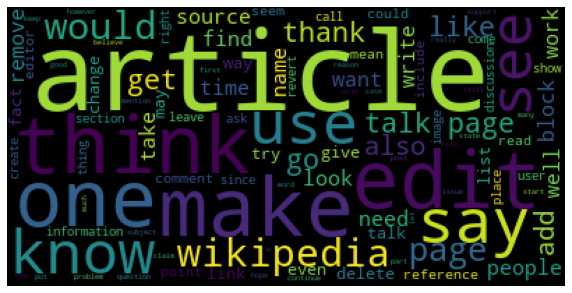

In [44]:
# Проведем частотный анализ и выведем облако наиболее часто повторяющихся слов

#зададим стоп-слова
stopwords = set(nltk_stopwords.words('english'))

#преобразуем столбец с текстом
text = ' '.join(df['lemm_text'])

#генерируем облако слов
cloud = WordCloud().generate(text)

#задаем параметры метода облака слов
cloud = WordCloud(stopwords=stopwords, max_words=100).generate(text)

plt.figure(figsize=(10,6))
plt.imshow(cloud)
plt.axis('off')
None

В ходе подготовки данных были выполнены следующие этапы:
1. загруженны необходимые библиотеки и сами данные;
2. удален ненужный столбец;
3. текст очищен от символов кроме букв и цифр;
4. исследован баланс классов;
6. текст лемматизирован с учетом частей речи.

Далее обучим несколько моделей.

## Обучение

In [13]:
#разделим выборки для дальнейшей векторизации признаков
X = df['lemm_text']
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=12345)

In [14]:
#посмотрим на размер полученных выборок
print('тренировочные выборки')
display(X_train.shape)
display(y_train.shape)
print('тестовые выборки')
display(X_test.shape)
display(y_test.shape)

(119469,)

(39823,)

(119469,)

(39823,)

In [15]:
# зададим метод векторизации
# также сразу передадим параметр для создания n-грамм. 
# таким образом будет учтен контекст

# nltk.download('stopwords')

count_tf_idf = TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
                               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)

In [16]:
#зададим метрики, которые будут вычисляться для всех моделей
scorers = {
    'roc_auc_score': make_scorer(roc_auc_score),
    'f1_score': make_scorer(f1_score),
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score)
}

### Модель Логистическая регрессия

In [17]:
#выберем диапазон параметров для варьирования
param_search_l = {'model__C': [0.1, 1, 10]}

In [18]:
#задаим параметры для модели LogisticRegression

pipe_l = Pipeline([('vect', count_tf_idf),
                   ('model', LogisticRegression(random_state=12, max_iter=200, class_weight='balanced'))])

gsearch_l = GridSearchCV(estimator=pipe_l, 
                       cv=3, 
                       param_grid=param_search_l,
                        refit='f1_score',
                       scoring=scorers,
                        n_jobs=-1)

In [19]:
#обучим модель LightGBM
gsearch_l.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.9, min_df=3,
                                                        ngram_range=(1, 3),
                                                        smooth_idf=1,
                                                        stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
            

In [20]:
#далее посмотрим на получившийся результат
print( 'F1 для модели LightGBM:', "%.2f" % gsearch_l.best_score_)
print( 'Лучший набор параметров модели LightGBM:', gsearch_l.best_params_)

F1 для модели LightGBM: 0.77
Лучший набор параметров модели LightGBM: {'model__C': 10}


In [21]:
#зададим функцию для вывода интересующих метрик

def results_gm(model):
    
    results = pd.DataFrame(model.cv_results_)
    table_results = (results[['mean_test_f1_score', 'mean_test_roc_auc_score', 
                    'mean_test_precision_score', 'mean_test_recall_score']].round(3).head(5)
                     .sort_values(by='mean_test_f1_score', ascending=False))
    
    return table_results

In [22]:
#сохраним результаты в таблице и выведем результаты
tadle_results_l = results_gm(gsearch_l)

tadle_results_l

,mean_test_f1_score,mean_test_roc_auc_score,mean_test_precision_score,mean_test_recall_score
2,0.773,0.879,0.760,0.786
3,0.765,0.864,0.779,0.752
1,0.744,0.889,0.679,0.823
0,0.699,0.876,0.614,0.810


Основные метрики для кросс-валидации получились неплохие. Целевой показатель F1 соотвествует требованию проекта, а также метрика ROC-AUC достаточно высокая. 

### Модель LightGBM

In [23]:
#далее обучим бустинговую модель

#выберем диапазон параметров для варьирования
param_search_lgb = {'model__max_depth': [4, 6, 10, 12],
                    'model__num_leaves': [30, 40, 50, 60]}

In [24]:
#задаим постоянные параметры для модели LightGBM
params_lgb = {'n_estimators': 100,
              'learning_rate': 0.3,
              'class_weight': 'balanced',
              'random_state': 42}

pipe_lgb = Pipeline([
    ('vect', count_tf_idf),
    ('model', LGBMClassifier(**params_lgb))])

gsearch_lgb = GridSearchCV(estimator=pipe_lgb, 
                       cv=3, 
                       param_grid=param_search_lgb,
                        refit='f1_score',
                       scoring=scorers,
                           n_jobs=-1)

In [25]:
#обучим модель LightGBM
gsearch_lgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.9, min_df=3,
                                                        ngram_range=(1, 3),
                                                        smooth_idf=1,
                                                        stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
            

In [26]:
#далее посмотрим на получившийся результат
print( 'F1 для модели LightGBM:', "%.2f" % gsearch_lgb.best_score_)
print( 'Лучший набор параметров модели LightGBM:', gsearch_lgb.best_params_)

F1 для модели LightGBM: 0.74
Лучший набор параметров модели LightGBM: {'model__max_depth': 12, 'model__num_leaves': 60}


In [27]:
#сохраним результаты в таблице и выведем результаты
tadle_results_lgb = results_gm(gsearch_lgb)

tadle_results_lgb

,mean_test_f1_score,mean_test_roc_auc_score,mean_test_precision_score,mean_test_recall_score
4,0.730,0.871,0.683,0.784
0,0.718,0.864,0.672,0.771
1,0.718,0.864,0.672,0.771
2,0.718,0.864,0.672,0.771
3,0.718,0.864,0.672,0.771


Модель LightGBM показала результаты хуже, чем на линейной модели. 

### Модель SGDClassifier

In [28]:
#задаим постоянные параметры для модели SGDClassifier
params_sgd = {
    'max_iter': 100,
    'tol': 0.001,
    'class_weight': 'balanced',
    'random_state': 42}

param_search_sgb = {'model__alpha': [0.0001, 0.001, 0.01, 0.1]}

pipe_sgd = Pipeline([
    ('vect', count_tf_idf),
    ('model', SGDClassifier(**params_sgd))])

gsearch_sgd = GridSearchCV(estimator=pipe_sgd, 
                       cv=3, 
                       param_grid=param_search_sgb,
                       refit='f1_score',
                       scoring=scorers,
                          n_jobs=-1)

In [29]:
#обучим модель SGDClassifier
gsearch_sgd.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.9, min_df=3,
                                                        ngram_range=(1, 3),
                                                        smooth_idf=1,
                                                        stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
            

In [30]:
#далее посмотрим на получившийся результат
print( 'F1 для модели SGDClassifier:', "%.2f" % gsearch_sgd.best_score_)
print( 'Лучший набор параметров модели SGDClassifier:', gsearch_sgd.best_params_)

F1 для модели SGDClassifier: 0.73
Лучший набор параметров модели SGDClassifier: {'model__alpha': 0.0001}


In [31]:
#сохраним результаты в таблице и выведем результаты для нескольких итераций валидации
tadle_results_sgd = results_gm(gsearch_sgd)

tadle_results_sgd

,mean_test_f1_score,mean_test_roc_auc_score,mean_test_precision_score,mean_test_recall_score
0,0.734,0.889,0.660,0.826
1,0.712,0.821,0.768,0.665
2,0.491,0.714,0.577,0.708
3,0.234,0.574,0.411,0.719


Результаты модели SGD оказались немного лучше чем простая модель Логистической регрессии. Алгоритм хорошо находит долю объектов положительного класса из всех объектов положительного класса - показатель recall на валидационных выборках выше, чем для линейной модели.

## Тестирование модели

Лучшие результаты показала модель Логичтисекая регрессия. Получим результаты на тестовых данных.

In [35]:
model_test=gsearch_l.best_estimator_

predicted_test = model_test.predict(X_test)

# вычислим вероятность положительного класса для всех моделей
probabilities_test = model_test.predict_proba(X_test)

#вычислим значение auc_roc
auc_roc_test = roc_auc_score(y_test, probabilities_test[:, 1])

print('AUC_ROC при тестировании:',"%.2f" % auc_roc_test)
print("F1 при тестировании:", "%.2f" % f1_score(y_test, predicted_test))

AUC_ROC при тестировании: 0.97
F1 при тестировании: 0.78


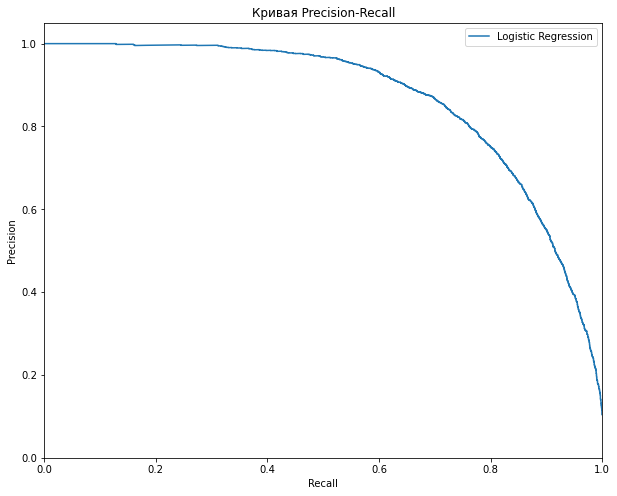

In [33]:
# посмотрим на изменение метрик полноты и точности при изменении порога классификации 
#для лучшей модели на тестовых данных

# вычислим значения точности, полноты и порога
precision, recall, thresholds = precision_recall_curve(y_test, 
                                                       probabilities_test[:, 1]) # Логистическая регрессия
# выведем графики изменения кривых по мере изменения порога 
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, linestyle='-', label='Logistic Regression')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

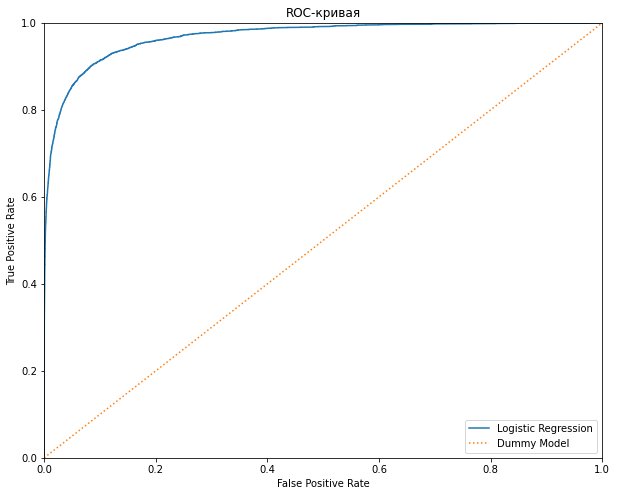

In [34]:
# посмотрим на кривую ошибок при изменении порога классификации
#для лучшей модели на тестовых данных

# вычислим значения ошибок и порога
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test[:, 1])

# выведем графики кривой ошибок для всех моделей
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linestyle='-', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle=':', label='Dummy Model') # добавим график для случаной модели
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')
plt.show()

ROC- кривые показывают отношение ложноположительных ответов (FPR) и истинно положительных ответов (TPR) по мере изменения порога классификации. Для оценки качества модели используется площадь под соотвествующей кривой - метрика AUC-ROC. Судя по характеру кривой ошибок и площади под кривой, качество предсказаний удовлетворительное. 

## Выводы

В ходе проекта выполнена задача обучения модели и классификации комментариев на позитивные и негативные. 

Выполнена цель проекта - построена модель Логистической регрессии со значением метрики качества *F1* выше 0.75. 

**Выполнены следующие этапы и получены результаты**

1. Данные загружены и подготовлены:
   - исследован и устранен дисбаланс классов;
   - текст лемматизирован и преобразован в вектор признаков.
2. Обучены модели и получены результаты на валидационной выборке:
   - Логистическая регрессия: F1=0.77; 
   - LightGBM: F1=0.74;
   - SGDClassifier: F1=0.73;
3. Лучшие результаты на тестовой выборке показала модель Логистическая регрессия: F1=0.78; AUC-ROC=0.97.